# BIKE SHARING ASIGNMENT
### Build a multiple linear regression model for the prediction of demand for shared bikes
- A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario
- So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end

### The company wants to know:

- Which variables are significant in predicting the demand for shared bikes. 
- How well those variables describe the bike demands

### day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [1]:
# Importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# importing machine learning libraries

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
# Filtering out the warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Displaying the 150 columns and rows

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)

## Reading the dataset

In [5]:
# reading the CSV file using pandas 'read_csv' method and storing it in bikes dataframe
# also diplaying the first 5 rows 
data = pd.read_csv('day.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Inspecting the Dataframe
Checking the Dataframe dimension, null values,summary of the dataframe  

In [6]:
# Checking the number of rows and columns in the dataframe using ".shape" attribute

data.shape

(730, 16)

In [7]:
# Checking the column-wise info of the dataframe using ".info()" method

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [8]:
# Checking the summary for the numeric columns 

data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


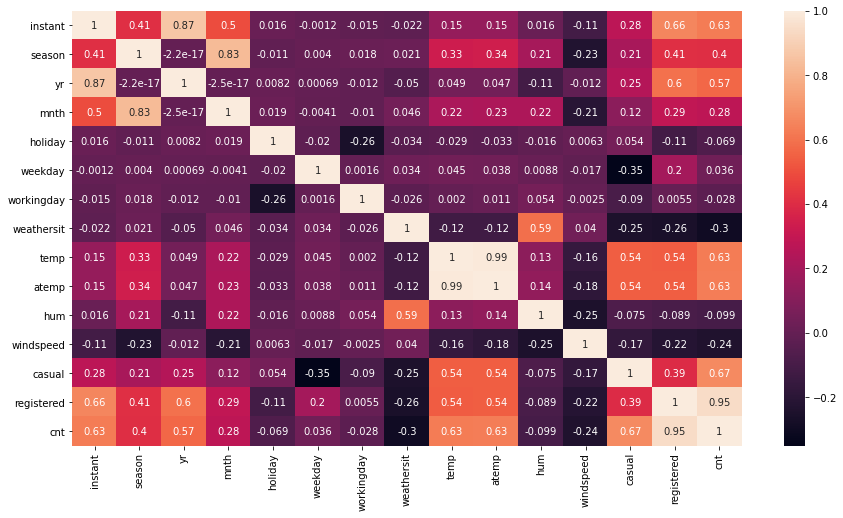

In [9]:
# plotting the heatmap(sns.heatmap()) to to check the correlation(.corr()) between the above columns and the target variable 

plt.figure(figsize=(15,8))
sns.heatmap(data.corr(),annot=True)
plt.show()

### Dropping the following columns
- dteday 
- instant which nothing but the id number for each record
- atemp which represents the temperature itself and it is 0.99% correlated with temp
- casual and registers these are 

In [10]:
bikes = data.drop(['dteday','instant','atemp','casual','registered'],axis=1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,1,1,2,14.110847,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,43.6957,12.522300,1600


# Converting the numeric features to categorical as per the data dictionary
- season - spring, summer, fall and winter
- mnth - january to december
- weekday - sunday to saturday
- weathersit - clear,mist,light snow and heavy rain

In [11]:
# converting the categorical features to different sub-categorical levels 

bikes['season'] = bikes['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

bikes['mnth'] = bikes['mnth'].map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'june',7:'july',8:'aug',9:'sep',
                                                      10:'oct',11:'nov',12:'dec'})

bikes['weekday'] = bikes['weekday'].map({0:'sun',1:'mon',2:'tue',3:'wed',4:'thur',5:'fri',6:'sat'})

bikes['weathersit'] = bikes['weathersit'].map({1:'clear',2:'mist',3:'light snow',4:'heavy rain'})

In [12]:
# checking the head of the dataframe after conversion

bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,jan,0,mon,1,mist,14.110847,80.5833,10.749882,985
1,spring,0,jan,0,tue,1,mist,14.902598,69.6087,16.652113,801
2,spring,0,jan,0,wed,1,clear,8.050924,43.7273,16.636703,1349
3,spring,0,jan,0,thur,1,clear,8.200000,59.0435,10.739832,1562
4,spring,0,jan,0,fri,1,clear,9.305237,43.6957,12.522300,1600


# Data Visualization
- The function is created to plot. 
 1. the box plot between the categorical feature and Target variable
 2. Barplot for each categorical feature sum i.e total number and percentage of cnt for each categorical levels

In [13]:
# function to plot box plt and bar plot for each categorical feature

def predictor_info(predictor,x_title):
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.boxplot(x=predictor,y='cnt',data=bikes)
    plt.xlabel(x_title,fontdict={'fontsize':15,'color':'green'})
    plt.ylabel('Total Count',fontdict={'fontsize':15,'color':'green'})
    plt.title(x_title+' - '+'Total Counts\n',fontdict={'fontsize':20,'color':'brown'})
    
    plt.subplot(1,2,2)    
    grouped = bikes.groupby(predictor).sum()['cnt']
    axe = sns.barplot(grouped.index,grouped)
    plt.xlabel(x_title,fontdict={'fontsize':15,'color':'green'})
    plt.ylabel('')
    #plt.ylabel('Total Count',fontdict={'fontsize':15,'color':'green'})
    plt.title(x_title + ' - ' +'Total Count % \n',fontdict={'fontsize':20,'color':'brown'})
    
    for p in axe.patches:
        axe.annotate('{:.1f}%'.format((p.get_height()/bikes['cnt'].sum())*100), (p.get_x()+0.1,(p.get_height())))
        
    plt.tight_layout()
    plt.show()

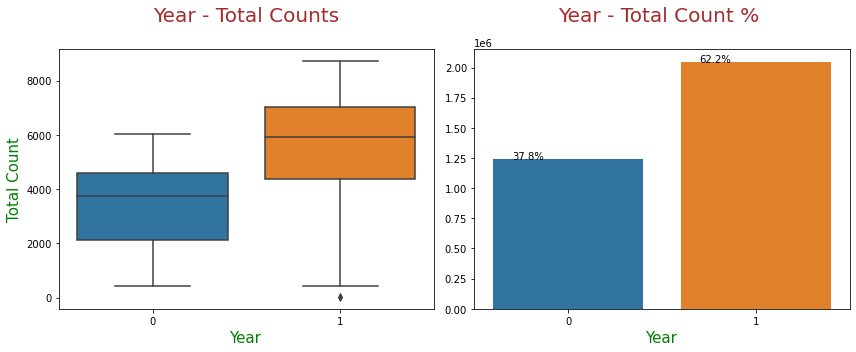

In [14]:
# plotting the users count over the years using predictor_info() function.

predictor_info('yr','Year')

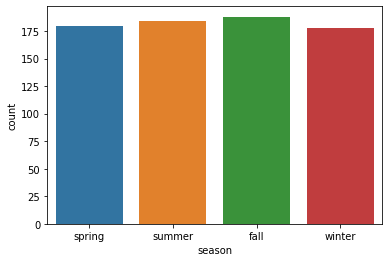

In [15]:
sns.countplot(x='season',data=bikes)
plt.show()

In [16]:
bikes['cnt'].sum()

3290845

In [17]:
bikes.groupby('season').sum()

,yr,holiday,workingday,temp,hum,windspeed,cnt
season,,,,,,,
fall,94,4,129,5444.232150,11909.4627,2167.708881,1061129
spring,90,7,121,2195.466294,10470.0644,2589.690251,469514
summer,92,4,129,4106.992509,11535.8493,2508.835904,918589
winter,89,6,125,3086.368275,11903.2013,2051.207311,841613


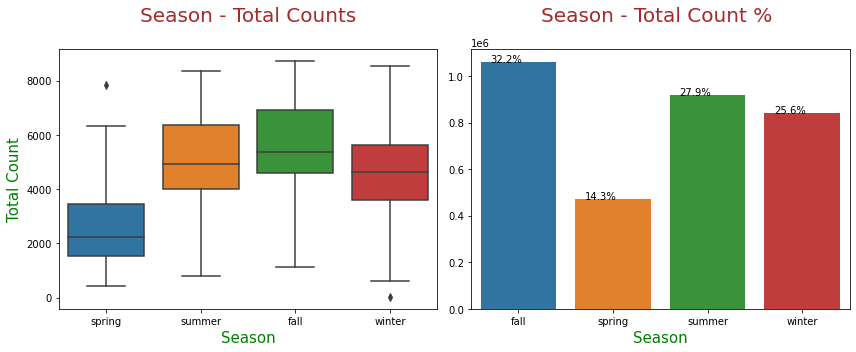

In [18]:
# plotting the users count for every season using predictor_info() function.

predictor_info('season','Season')

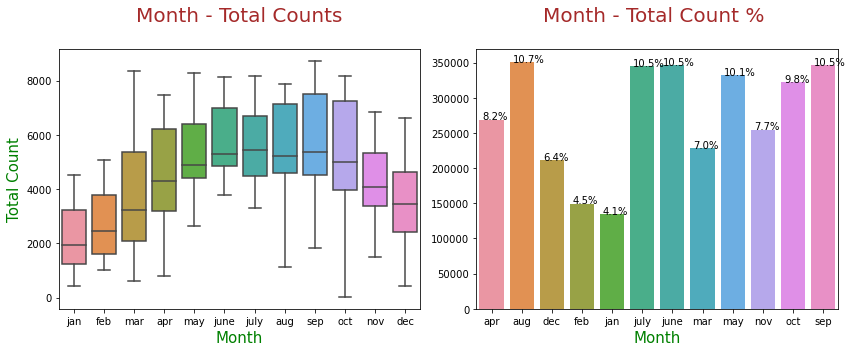

In [19]:
# plotting the users count over every month using predictor_info() function.

predictor_info('mnth','Month')

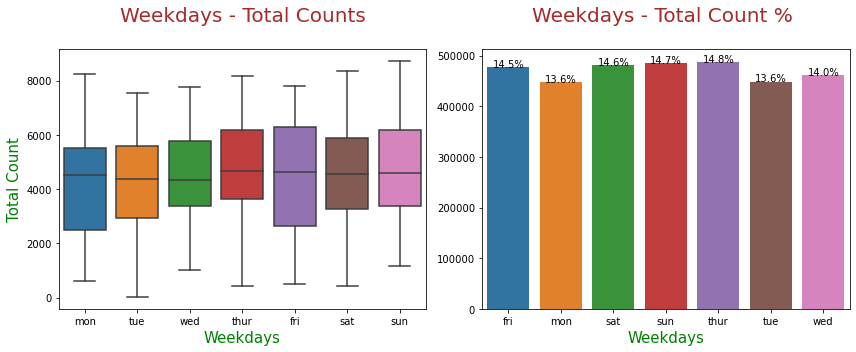

In [20]:
# plotting the users count for weekdays using predictor_info() function.

predictor_info('weekday','Weekdays')

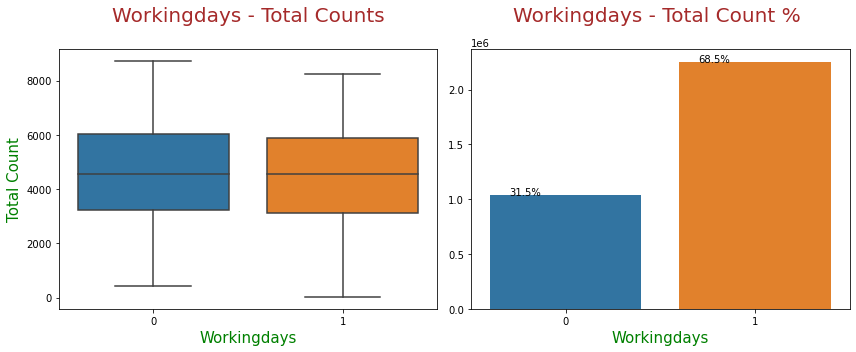

In [21]:
# plotting the users count for working and holodays using predictor_info() function.

predictor_info('workingday','Workingdays')

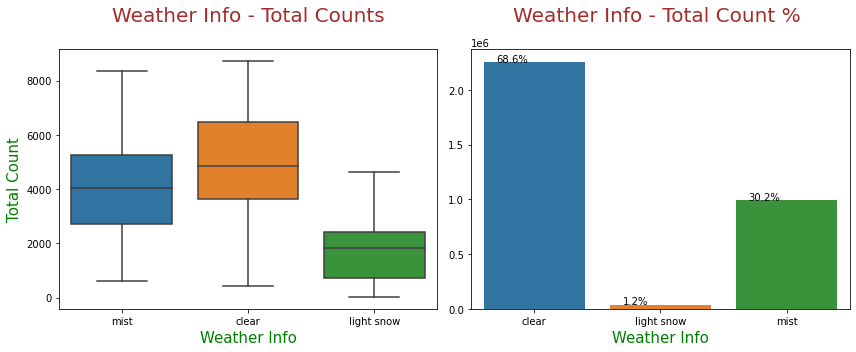

In [22]:
# plotting the users count for different weather conditions using predictor_info() function.

predictor_info('weathersit','Weather Info')

In [23]:
bikes[bikes['mnth']=='sep'].head(30)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
243,fall,0,sep,0,sat,0,clear,26.855000,63.9167,9.500332,5115
244,fall,0,sep,0,sun,0,mist,26.376653,72.7083,9.375243,4727
245,fall,0,sep,0,mon,1,clear,27.435847,71.6667,12.416775,4484
246,fall,0,sep,0,tue,1,clear,29.075847,74.2083,13.833289,4940
247,fall,0,sep,1,wed,0,mist,27.606653,79.0417,14.250632,3351
248,fall,0,sep,0,thur,1,light snow,22.140000,88.6957,23.044181,2710
249,fall,0,sep,0,fri,1,light snow,24.565847,91.7083,6.500394,1996
250,fall,0,sep,0,sat,0,light snow,25.990433,93.9565,12.914116,1842
251,fall,0,sep,0,sun,0,mist,26.650000,89.7917,8.333393,3544
252,fall,0,sep,0,mon,1,clear,27.060000,75.3750,10.291736,5345


In [24]:
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,jan,0,mon,1,mist,14.110847,80.5833,10.749882,985
1,spring,0,jan,0,tue,1,mist,14.902598,69.6087,16.652113,801
2,spring,0,jan,0,wed,1,clear,8.050924,43.7273,16.636703,1349
3,spring,0,jan,0,thur,1,clear,8.200000,59.0435,10.739832,1562
4,spring,0,jan,0,fri,1,clear,9.305237,43.6957,12.522300,1600


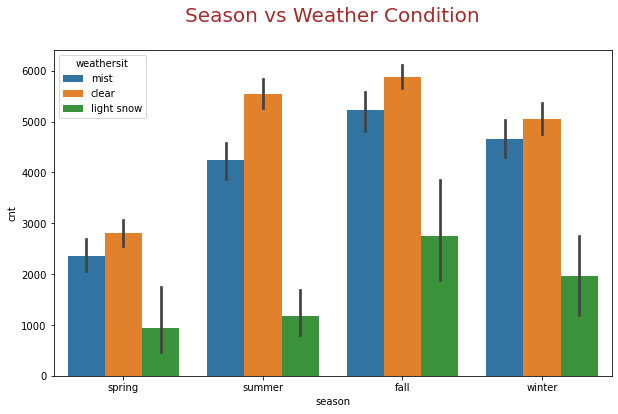

In [25]:
# plotting the barplot for 'season', 'cnt' and 'weathersit' 

plt.figure(figsize=(10,6))
sns.barplot(x='season',y='cnt',data=bikes,hue='weathersit')
plt.title('Season vs Weather Condition\n',fontdict={'color':'brown','fontsize':20})
plt.show()

# Convering to Dummies
- converting the column 'season', 'mnth' , 'weekday' and 'weathersit' to dummies and droping first coloum

In [26]:
# converting into dummies 

to_dumies = ['season','mnth','weekday','weathersit']

for i in to_dumies:
    dummie_vars = pd.get_dummies(bikes[i],drop_first=True)
    bikes = pd.concat([bikes,dummie_vars],axis=1)
    
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thur,tue,wed,light snow,mist
0,spring,0,jan,0,mon,1,mist,14.110847,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,spring,0,jan,0,tue,1,mist,14.902598,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,spring,0,jan,0,wed,1,clear,8.050924,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,spring,0,jan,0,thur,1,clear,8.200000,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,spring,0,jan,0,fri,1,clear,9.305237,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
bikes['weathersit'].value_counts()

clear         463
mist          246
light snow     21
Name: weathersit, dtype: int64

In [28]:
bikes.groupby('weathersit').sum()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thur,tue,wed,light snow,mist
weathersit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
clear,237,15,327,9710.591552,26187.0203,5901.826635,2257952,111,113,103,43,32,37,37,51,46,36,37,42,32,33,70,61,63,68,68,68,0,0
light snow,6,0,17,373.191963,1782.6322,342.373270,37869,4,3,10,0,3,1,1,1,0,2,0,3,5,3,4,3,1,4,1,2,21,0
mist,122,6,160,4749.275713,17848.9252,3073.242443,995024,65,68,65,19,27,18,24,10,14,24,25,15,25,24,31,40,40,32,36,34,0,246


In [29]:
# dropping the intial columns

bikes.drop(['season','mnth','weekday','weathersit'],axis=1,inplace=True)
bikes.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thur,tue,wed,light snow,mist
0,0,0,1,14.110847,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.902598,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Correlation 
- The variables temp, yr, june,sep... are possitively correlated with cnt
- The variables spring, jan, feb, light snow and windspeed are negatively correlated with cnt

In [30]:
# checking the correlation of the predictors with target(cnt) variable
 
bikes.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
temp          0.627044
yr            0.569728
june          0.195568
sep           0.194664
aug           0.182100
july          0.166236
summer        0.145325
may           0.132553
oct           0.108846
winter        0.064619
thur          0.038672
sun           0.033227
sat           0.025004
wed          -0.013282
workingday   -0.027640
nov          -0.040344
tue          -0.049471
mon          -0.052581
holiday      -0.068764
hum          -0.098543
mar          -0.128456
mist         -0.170686
dec          -0.173878
windspeed    -0.235132
light snow   -0.240602
feb          -0.273848
jan          -0.367167
spring       -0.561702
Name: cnt, dtype: float64

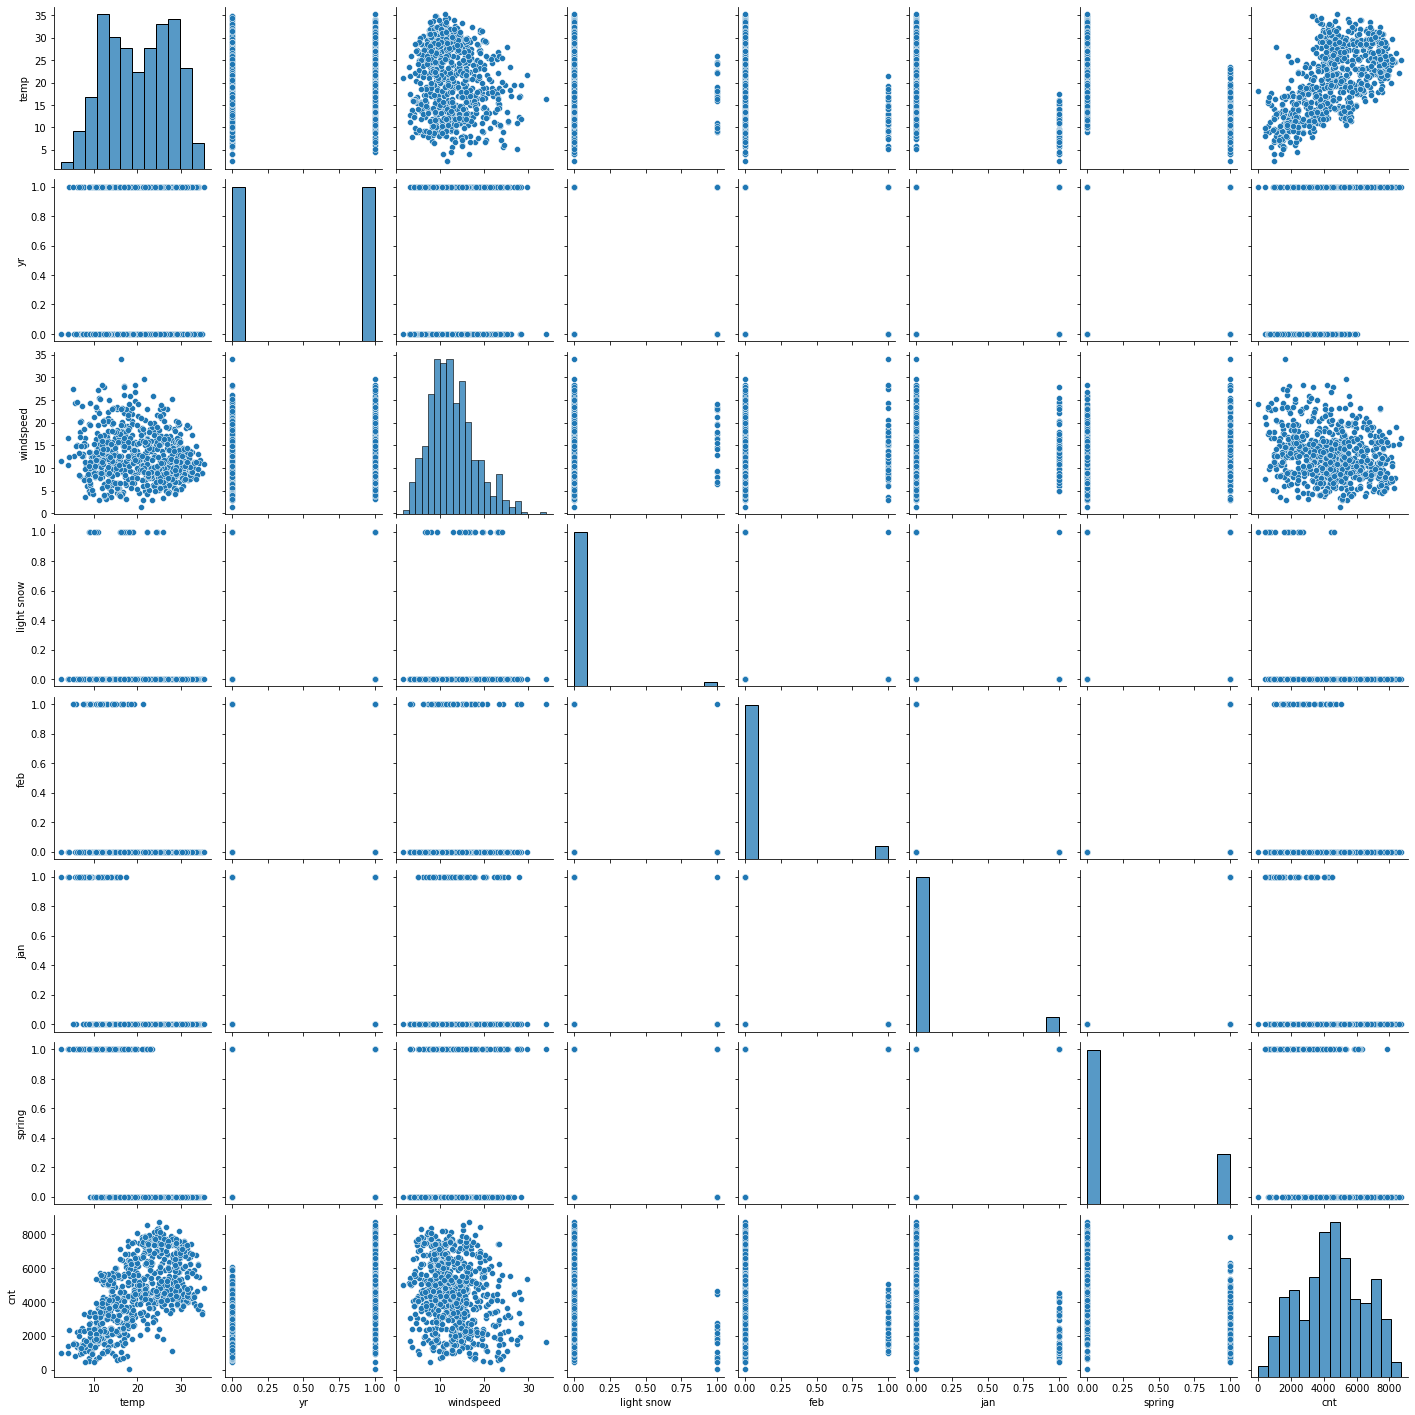

In [31]:
# plotting the scatter plot only for the predictors which are having good correlation with 'cnt'

sns.pairplot(bikes[['temp','yr','windspeed','light snow','feb','jan','spring','cnt']])
plt.show()

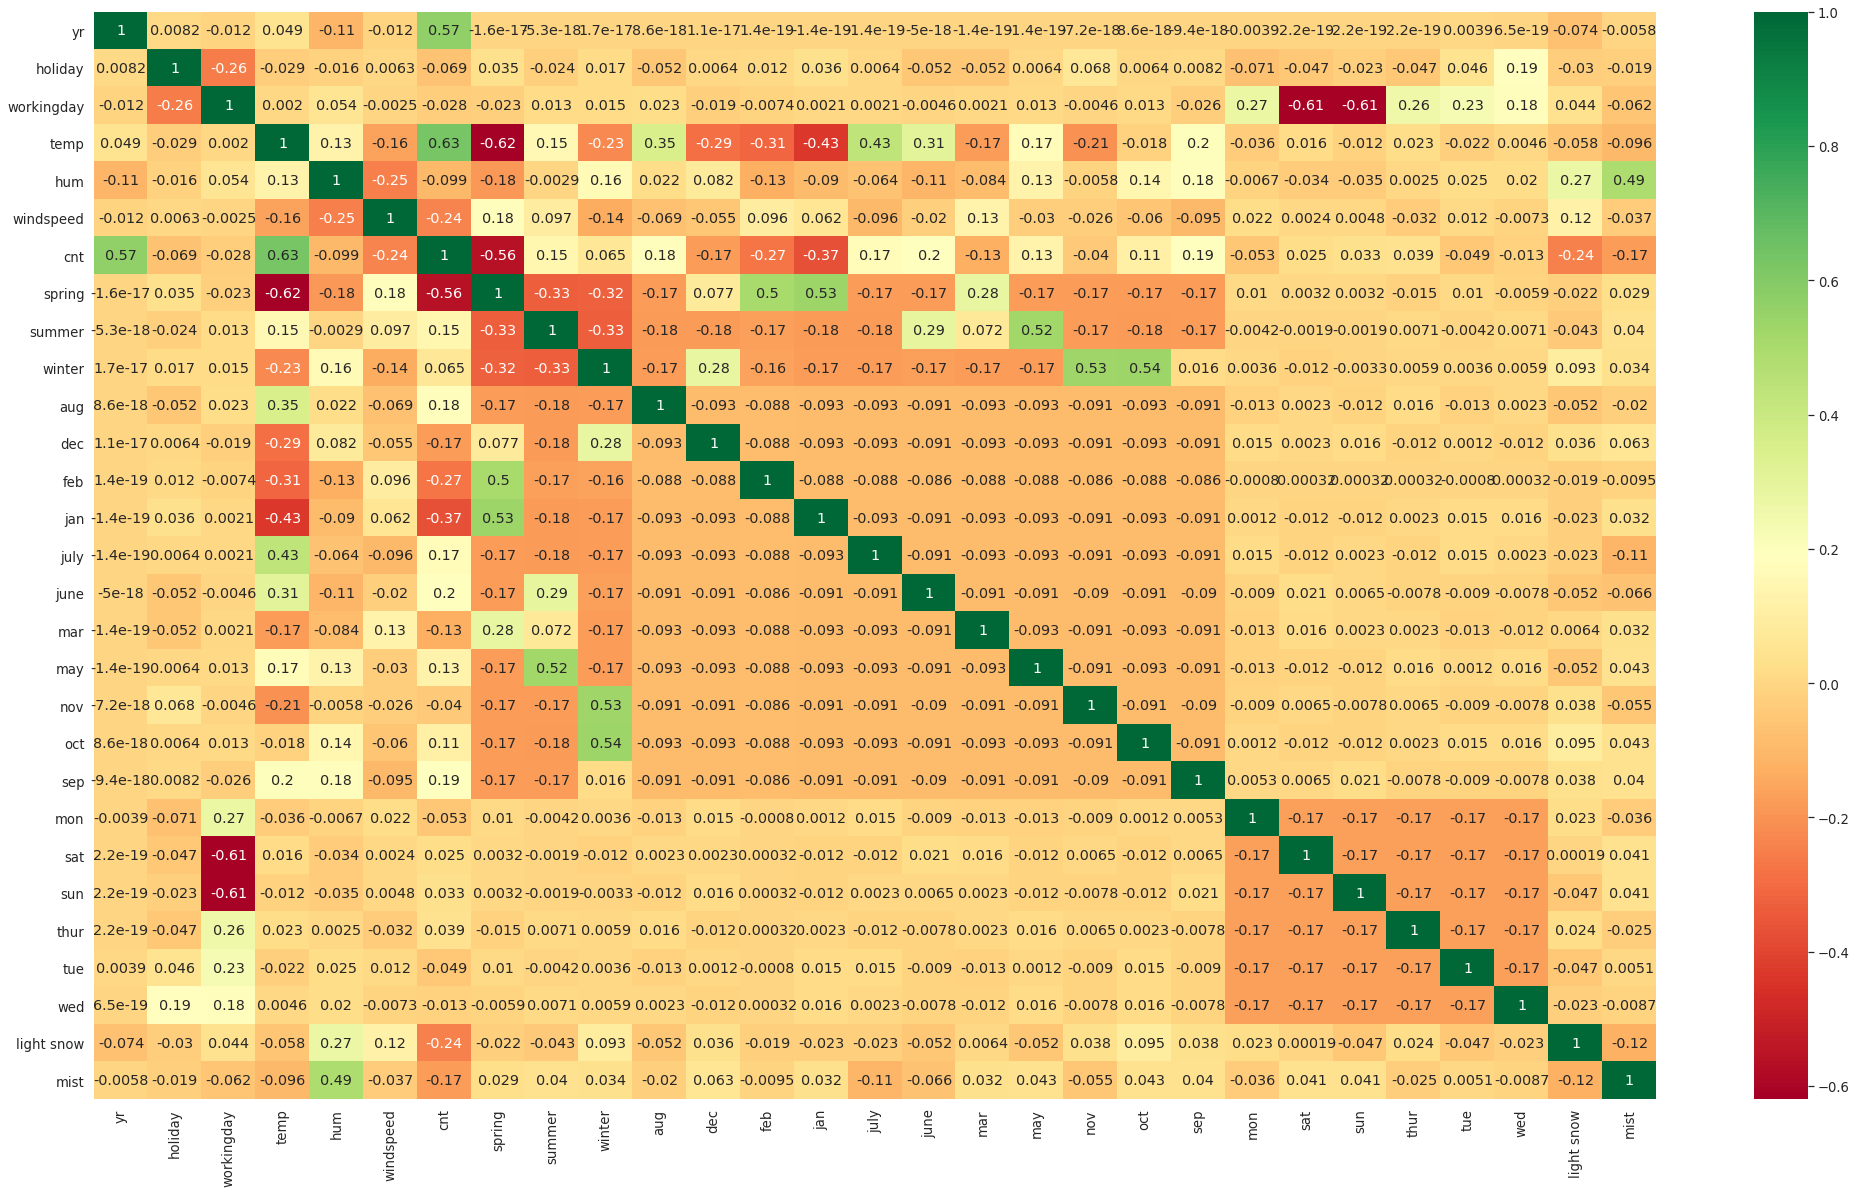

In [32]:
# pltting the heatmap for correlation matrix for the dataframe

plt.figure(figsize=(35,20))
sns.set(font_scale=1.2)
sns.heatmap(bikes.corr(),annot=True,cmap='RdYlGn')
plt.show()

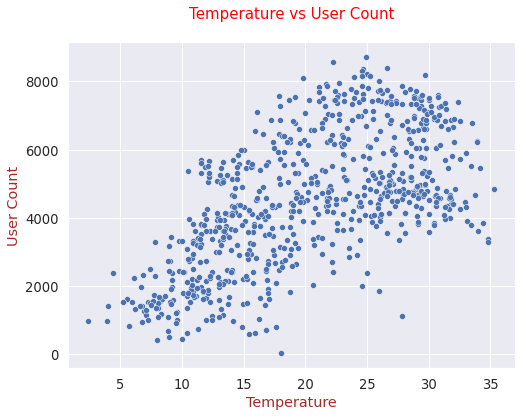

In [33]:
# ploting the scatter plot between 'cnt' and 'temp'

plt.figure(figsize=(8,6))
sns.scatterplot(x='temp',y='cnt',data=bikes)
plt.xlabel('Temperature',fontdict={'color':'brown'})
plt.ylabel('User Count',fontdict={'color':'brown'})
plt.title('Temperature vs User Count\n',fontdict={'fontsize':15, 'color':'red'})
plt.show()

# Splitting the data
- we will split the entire data into training dataset and testing dataset.
- we will fit the model on the training dataset and check the accuray of the model on test dataset.

In [34]:
# splitting the data into train and test with train_size = 0.75 and test_size = 0.25

df_train, df_test = train_test_split(bikes,test_size=0.25,random_state=100)

In [35]:
# cheking the shape of the split

print(df_train.shape)
print(df_test.shape)

(547, 29)
(183, 29)


In [36]:
# checking the head of the dataset

df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thur,tue,wed,light snow,mist
311,0,0,1,16.741653,72.1667,4.625513,4205,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
523,1,0,0,26.615847,46.7917,11.750661,7736,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
381,1,0,1,15.294763,71.6087,23.391710,2935,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
413,1,0,1,14.213347,53.4583,12.792243,4318,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
253,0,0,1,26.786653,71.3750,7.708618,5046,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


# Feature Scaling.
- feature scaling will be prefered most of the times for its quick results and interpretability of the variables.
- scaling will done when the scale between two features are high.
- The scaling will be done with MinMaxScale() which fits all the values in between 0 - 1.

In [37]:
# storing column names 'temp','hum','windspeed' and 'cnt' list.

var = ['temp','hum','windspeed','cnt']

In [38]:
# creating the scaler object.

scaler = MinMaxScaler()

In [39]:
# sacling selected column with fit_transform() method

df_train[var] = scaler.fit_transform(df_train[var])
df_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thur,tue,wed,light snow,mist
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.00000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
mean,0.508227,0.027422,0.718464,0.535543,0.650673,0.319317,0.511382,0.257770,0.244973,0.244973,0.093236,0.087751,0.073126,0.08958,0.071298,0.078611,0.096892,0.084095,0.082267,0.087751,0.080439,0.151737,0.124314,0.133455,0.140768,0.160878,0.144424,0.027422,0.349177
std,0.500390,0.163460,0.450160,0.225446,0.144515,0.169239,0.225008,0.437807,0.430465,0.430465,0.291029,0.283192,0.260582,0.28584,0.257557,0.269376,0.296082,0.277784,0.275022,0.283192,0.272220,0.359094,0.330242,0.340377,0.348100,0.367754,0.351841,0.163460,0.477146
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.336998,0.538858,0.197844,0.350437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.535847,0.655216,0.294101,0.514266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.753113,0.413761,0.682697,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model Building.
- we will choose the linear regression model as the target varible is continous and there is some collinearity exist between the predictors and Target variable

In [40]:
# spling the data into target variable and predictors.

Y_train = df_train.pop('cnt')
X_train = df_train

## Model 1 : with all the features
considering all the feature and determing the significance of the predictors and the model

In [41]:
# adding const to the dataset for fitting the model with statsmodels library.
# fitting the model with OLS method.

X_train_lm = sm.add_constant(X_train)
lr = sm.OLS(Y_train, X_train_lm).fit()
lr.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     107.8
Date:                Mon, 10 May 2021   Prob (F-statistic):          6.52e-196
Time:                        16:08:39   Log-Likelihood:                 565.52
No. Observations:                 547   AIC:                            -1073.
Df Residuals:                     518   BIC:                            -948.2
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3695      0.083      4.448      0.000       0.206       0.533
yr             0.2301      0.008     29.627      0.000       0.215       0.245
holiday       -0.1379      0.065     -2.131      0.034      -0.265      -0.011
workingday    -0.0424      0.070     -0.609      0.543      -0.179       0.094
temp           0.4403      0.044      9.939      0.000       0.353       0.527
hum           -0.1521      0.038     -4.043      0.000      -0.226      -0.078
windspeed     -0.1757      0.025     -7.092      0.000      -0.224      -0.127
spring        -0.0489      0.029     -1.705      0.089      -0.105       0.007
summer         0.0469      0.025      1.857      0.064      -0.003       0.096
winter         0.1187      0.027      4.465      0.000       0.066       0.171
aug            0.0273      0.033      0.841      0.401      -0.037       0.091
dec           -0.0504      0.032     -1.565      0.118      -0.114       0.013
feb           -0.0306      0.032     -0.965      0.335      -0.093       0.032
jan           -0.0567      0.033     -1.742      0.082      -0.121       0.007
july          -0.0276      0.034     -0.813      0.417      -0.094       0.039
june           0.0144      0.024      0.610      0.542      -0.032       0.061
mar            0.0045      0.024      0.184      0.854      -0.043       0.052
may            0.0198      0.021      0.966      0.334      -0.020       0.060
nov           -0.0442      0.035     -1.259      0.209      -0.113       0.025
oct            0.0081      0.034      0.235      0.814      -0.059       0.075
sep            0.0891      0.031      2.888      0.004       0.028       0.150
mon           -0.0275      0.014     -1.953      0.051      -0.055       0.000
sat           -0.0377      0.070     -0.538      0.591      -0.176       0.100
sun           -0.0317      0.070     -0.452      0.651      -0.169       0.106
thur           0.0010      0.014      0.072      0.943      -0.027       0.029
tue           -0.0273      0.014     -1.964      0.050      -0.055    1.28e-05
wed           -0.0083      0.014     -0.575      0.565      -0.037       0.020
light snow    -0.2552      0.026     -9.734      0.000      -0.307      -0.204
mist          -0.0582      0.010     -5.790      0.000      -0.078      -0.038
==============================================================================
Omnibus:                       86.642   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.065
Skew:                          -0.788   Prob(JB):                     4.05e-51
Kurtosis:                       5.775   Cond. No.                         72.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

## Checking VIF
Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating VIF is

In [42]:
# determing the VIF of the predictors

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,66.61
3,temp,42.97
4,hum,42.07
6,spring,14.05
22,sun,12.33
8,winter,11.96
21,sat,11.69
7,summer,9.77
18,oct,6.94
17,nov,6.83


#### In the above model the R2 and Adj-R2 is very good but there are many predictors are having the p-value > 0.05 and VIF > 5, we need to remove the insignificant predictors from the model based on p-value and VIF to reach to a good predicting model. 

# Model 2 - wirh RFE = 15.
### RFE - Recursive feature elimination.
- manually removing predictor one by one and checking the p-values and VIF's is quit time consuming and and difficult let's use the built in library (automated approach)which take cares of removing the insignificat predictors.

In [43]:
# fitting the regression model with sklearn library and finding top 8 good predictors with RFE.

lm2 = LinearRegression()                        # creating the object .
lm2.fit(X_train, Y_train)                       # fitting the model with train and test dataset.

rfe = RFE(lm2, 15)                              # cearting the object and providing feature required.
rfe = rfe.fit(X_train, Y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_)) # printing the result of RFE.

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 5),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('aug', False, 8),
 ('dec', True, 1),
 ('feb', False, 2),
 ('jan', True, 1),
 ('july', True, 1),
 ('june', False, 10),
 ('mar', False, 13),
 ('may', False, 9),
 ('nov', True, 1),
 ('oct', False, 12),
 ('sep', True, 1),
 ('mon', False, 3),
 ('sat', False, 6),
 ('sun', False, 7),
 ('thur', False, 14),
 ('tue', False, 4),
 ('wed', False, 11),
 ('light snow', True, 1),
 ('mist', True, 1)]

In [44]:
# storing the columns that supports the RFE in X_train_rfe

col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_train_rfe.head()

,yr,holiday,temp,hum,windspeed,spring,summer,winter,dec,jan,july,nov,sep,light snow,mist
311,0,0,0.435124,0.743667,0.057471,0,0,1,0,0,0,1,0,0,0
523,1,0,0.735215,0.482181,0.286093,0,1,0,0,0,0,0,0,0,0
381,1,0,0.391151,0.737917,0.659615,1,0,0,0,1,0,0,0,0,1
413,1,0,0.358285,0.550880,0.319514,1,0,0,0,0,0,0,0,0,0
253,0,0,0.740406,0.735509,0.156398,0,0,0,0,0,0,0,1,0,0


In [45]:
# adding const to the dataset for fitting the model with statsmodels library.
# fitting the model with OLS method.

X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(Y_train,X_train_rfe).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     198.0
Date:                Mon, 10 May 2021   Prob (F-statistic):          3.86e-206
Time:                        16:08:40   Log-Likelihood:                 556.10
No. Observations:                 547   AIC:                            -1080.
Df Residuals:                     531   BIC:                            -1011.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3182      0.035      9.135      0.000       0.250       0.387
yr             0.2291      0.008     29.648      0.000       0.214       0.244
holiday       -0.1052      0.024     -4.446      0.000      -0.152      -0.059
temp           0.4818      0.035     13.688      0.000       0.413       0.551
hum           -0.1606      0.037     -4.396      0.000      -0.232      -0.089
windspeed     -0.1810      0.025     -7.373      0.000      -0.229      -0.133
spring        -0.0683      0.020     -3.392      0.001      -0.108      -0.029
summer         0.0409      0.015      2.800      0.005       0.012       0.070
winter         0.1090      0.017      6.436      0.000       0.076       0.142
dec           -0.0433      0.016     -2.655      0.008      -0.075      -0.011
jan           -0.0388      0.017     -2.283      0.023      -0.072      -0.005
july          -0.0563      0.018     -3.138      0.002      -0.091      -0.021
nov           -0.0453      0.018     -2.501      0.013      -0.081      -0.010
sep            0.0721      0.016      4.457      0.000       0.040       0.104
light snow    -0.2499      0.026     -9.610      0.000      -0.301      -0.199
mist          -0.0548      0.010     -5.473      0.000      -0.074      -0.035
==============================================================================
Omnibus:                       73.472   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.272
Skew:                          -0.693   Prob(JB):                     9.68e-41
Kurtosis:                       5.483   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Checking VIF

In [46]:
# determing the VIF of the predictors

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,84.07
6,spring,5.38
3,temp,4.35
8,winter,3.67
7,summer,2.73
4,hum,1.93
12,nov,1.72
10,jan,1.63
15,mist,1.58
9,dec,1.48


### Outcome from model - 2 
- The model looks good with good R2 and Adj R2 and all the predictors having significant p-values and spring and temp has more VIF.
- In the above model the predictor "jan" has significant p-value - 0.023 and VIF - 1.63 but it has very low predictive power of just (-0.0388) let's drop this predictor to make the model more simpler.

# Model - 3 Manual Elimination.

In [47]:
# dropping the column 'jan' from the train dataset

X_train_man = X_train_rfe.drop('jan',axis=1)
X_train_man.head()

,const,yr,holiday,temp,hum,windspeed,spring,summer,winter,dec,july,nov,sep,light snow,mist
311,1.0,0,0,0.435124,0.743667,0.057471,0,0,1,0,0,1,0,0,0
523,1.0,1,0,0.735215,0.482181,0.286093,0,1,0,0,0,0,0,0,0
381,1.0,1,0,0.391151,0.737917,0.659615,1,0,0,0,0,0,0,0,1
413,1.0,1,0,0.358285,0.550880,0.319514,1,0,0,0,0,0,0,0,0
253,1.0,0,0,0.740406,0.735509,0.156398,0,0,0,0,0,0,1,0,0


In [48]:
# adding const to the dataset for fitting the model with statsmodels library.
# fitting the model with OLS method.

lm3 = sm.OLS(Y_train,X_train_man).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     210.1
Date:                Mon, 10 May 2021   Prob (F-statistic):          3.45e-206
Time:                        16:08:41   Log-Likelihood:                 553.43
No. Observations:                 547   AIC:                            -1077.
Df Residuals:                     532   BIC:                            -1012.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3008      0.034      8.815      0.000       0.234       0.368
yr             0.2284      0.008     29.465      0.000       0.213       0.244
holiday       -0.1076      0.024     -4.535      0.000      -0.154      -0.061
temp           0.5079      0.033     15.204      0.000       0.442       0.574
hum           -0.1677      0.037     -4.590      0.000      -0.239      -0.096
windspeed     -0.1760      0.025     -7.169      0.000      -0.224      -0.128
spring        -0.0708      0.020     -3.507      0.000      -0.111      -0.031
summer         0.0457      0.015      3.146      0.002       0.017       0.074
winter         0.1135      0.017      6.723      0.000       0.080       0.147
dec           -0.0332      0.016     -2.103      0.036      -0.064      -0.002
july          -0.0582      0.018     -3.236      0.001      -0.094      -0.023
nov           -0.0396      0.018     -2.197      0.028      -0.075      -0.004
sep            0.0742      0.016      4.570      0.000       0.042       0.106
light snow    -0.2454      0.026     -9.427      0.000      -0.297      -0.194
mist          -0.0543      0.010     -5.405      0.000      -0.074      -0.035
==============================================================================
Omnibus:                       69.589   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.817
Skew:                          -0.661   Prob(JB):                     2.97e-38
Kurtosis:                       5.416   Cond. No.                         20.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# checking the VIF of the predictors

vif = pd.DataFrame()
vif['Features'] = X_train_man.columns
vif['VIF'] = [variance_inflation_factor(X_train_man.values, i) for i in range(X_train_man.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,80.06
6,spring,5.36
3,temp,3.89
8,winter,3.62
7,summer,2.68
4,hum,1.91
11,nov,1.69
14,mist,1.58
10,july,1.47
9,dec,1.37


### Outcome from model - 3
- The model looks good with good R2 and Adj R2 and all the predictors having significant p-values and VIF only for spring > 5.
- In the above model the predictor "dec" has significant p-value - 0.036 and VIF - 1.37 but it has very low predictive power of just (-0.0332) let's drop this predictor to make the model more simpler.

# Model - 4 Manual Elimination.

In [50]:
# dropping the "dec" predictor

X_train_man = X_train_man.drop('dec',axis=1)
X_train_man.head()

,const,yr,holiday,temp,hum,windspeed,spring,summer,winter,july,nov,sep,light snow,mist
311,1.0,0,0,0.435124,0.743667,0.057471,0,0,1,0,1,0,0,0
523,1.0,1,0,0.735215,0.482181,0.286093,0,1,0,0,0,0,0,0
381,1.0,1,0,0.391151,0.737917,0.659615,1,0,0,0,0,0,0,1
413,1.0,1,0,0.358285,0.550880,0.319514,1,0,0,0,0,0,0,0
253,1.0,0,0,0.740406,0.735509,0.156398,0,0,0,0,0,1,0,0


In [51]:
lm4 = sm.OLS(Y_train,X_train_man).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     224.5
Date:                Mon, 10 May 2021   Prob (F-statistic):          2.02e-206
Time:                        16:08:41   Log-Likelihood:                 551.16
No. Observations:                 547   AIC:                            -1074.
Df Residuals:                     533   BIC:                            -1014.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2883      0.034      8.552      0.000       0.222       0.354
yr             0.2282      0.008     29.344      0.000       0.213       0.243
holiday       -0.1098      0.024     -4.617      0.000      -0.157      -0.063
temp           0.5266      0.032     16.299      0.000       0.463       0.590
hum           -0.1742      0.037     -4.770      0.000      -0.246      -0.102
windspeed     -0.1737      0.025     -7.058      0.000      -0.222      -0.125
spring        -0.0651      0.020     -3.243      0.001      -0.105      -0.026
summer         0.0500      0.014      3.471      0.001       0.022       0.078
winter         0.1083      0.017      6.464      0.000       0.075       0.141
july          -0.0585      0.018     -3.243      0.001      -0.094      -0.023
nov           -0.0260      0.017     -1.541      0.124      -0.059       0.007
sep            0.0784      0.016      4.853      0.000       0.047       0.110
light snow    -0.2404      0.026     -9.244      0.000      -0.292      -0.189
mist          -0.0528      0.010     -5.254      0.000      -0.073      -0.033
==============================================================================
Omnibus:                       65.297   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.563
Skew:                          -0.639   Prob(JB):                     4.51e-34
Kurtosis:                       5.259   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
vif = pd.DataFrame()
vif['Features'] = X_train_man.columns
vif['VIF'] = [variance_inflation_factor(X_train_man.values, i) for i in range(X_train_man.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,77.60
6,spring,5.27
3,temp,3.62
8,winter,3.54
7,summer,2.62
4,hum,1.90
13,mist,1.57
9,july,1.47
10,nov,1.47
11,sep,1.32


### Outcome from model - 4
- The model looks good with good R2 and Adj R2 and all the predictors having significant p-values except for "nov" and high VIF only for spring > 5.
- In the above model the predictor "nov" has high p-value - 0.124 and low VIF - 1.47 but it has very low predictive power of just (-0.0260) let's drop this predictor to make the model more simpler.

# Model - 5 Manual Elimination.

In [53]:
# dropping the "nov" predictor.

X_train_man = X_train_man.drop('nov',axis=1)
X_train_man.head()

,const,yr,holiday,temp,hum,windspeed,spring,summer,winter,july,sep,light snow,mist
311,1.0,0,0,0.435124,0.743667,0.057471,0,0,1,0,0,0,0
523,1.0,1,0,0.735215,0.482181,0.286093,0,1,0,0,0,0,0
381,1.0,1,0,0.391151,0.737917,0.659615,1,0,0,0,0,0,1
413,1.0,1,0,0.358285,0.550880,0.319514,1,0,0,0,0,0,0
253,1.0,0,0,0.740406,0.735509,0.156398,0,0,0,0,1,0,0


In [54]:
lm5 = sm.OLS(Y_train,X_train_man).fit()
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     242.4
Date:                Mon, 10 May 2021   Prob (F-statistic):          4.14e-207
Time:                        16:08:42   Log-Likelihood:                 549.95
No. Observations:                 547   AIC:                            -1074.
Df Residuals:                     534   BIC:                            -1018.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2806      0.033      8.406      0.000       0.215       0.346
yr             0.2283      0.008     29.328      0.000       0.213       0.244
holiday       -0.1140      0.024     -4.815      0.000      -0.160      -0.067
temp           0.5344      0.032     16.723      0.000       0.472       0.597
hum           -0.1729      0.037     -4.729      0.000      -0.245      -0.101
windspeed     -0.1752      0.025     -7.119      0.000      -0.224      -0.127
spring        -0.0601      0.020     -3.028      0.003      -0.099      -0.021
summer         0.0525      0.014      3.658      0.000       0.024       0.081
winter         0.1028      0.016      6.271      0.000       0.071       0.135
july          -0.0582      0.018     -3.221      0.001      -0.094      -0.023
sep            0.0811      0.016      5.046      0.000       0.050       0.113
light snow    -0.2391      0.026     -9.187      0.000      -0.290      -0.188
mist          -0.0524      0.010     -5.211      0.000      -0.072      -0.033
==============================================================================
Omnibus:                       63.013   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.612
Skew:                          -0.626   Prob(JB):                     3.96e-32
Kurtosis:                       5.186   Cond. No.                         19.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
vif = pd.DataFrame()
vif['Features'] = X_train_man.columns
vif['VIF'] = [variance_inflation_factor(X_train_man.values, i) for i in range(X_train_man.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,75.93
6,spring,5.13
3,temp,3.53
8,winter,3.38
7,summer,2.59
4,hum,1.90
12,mist,1.57
9,july,1.47
10,sep,1.30
11,light snow,1.23


### Outcome from model - 5
- The model looks good with good R2 and Adj R2 and all the predictors having significant p-values and high VIF only for spring > 5.
- In the above model the predictor "sep" has significant p-value - 0.000 and low VIF - 1.30 but it has very low predictive power of just (-0.08) let's drop this predictor to make the model more simpler.

# Model - 6 Manual Elimination.

In [56]:
# dropping the "july" predictor.

X_train_man = X_train_man.drop('sep',axis=1)
X_train_man.head()

,const,yr,holiday,temp,hum,windspeed,spring,summer,winter,july,light snow,mist
311,1.0,0,0,0.435124,0.743667,0.057471,0,0,1,0,0,0
523,1.0,1,0,0.735215,0.482181,0.286093,0,1,0,0,0,0
381,1.0,1,0,0.391151,0.737917,0.659615,1,0,0,0,0,1
413,1.0,1,0,0.358285,0.550880,0.319514,1,0,0,0,0,0
253,1.0,0,0,0.740406,0.735509,0.156398,0,0,0,0,0,0


In [57]:
lm6 = sm.OLS(Y_train,X_train_man).fit()
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     250.6
Date:                Mon, 10 May 2021   Prob (F-statistic):          6.15e-203
Time:                        16:08:43   Log-Likelihood:                 537.21
No. Observations:                 547   AIC:                            -1050.
Df Residuals:                     535   BIC:                            -998.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3020      0.034      8.918      0.000       0.235       0.369
yr             0.2287      0.008     28.728      0.000       0.213       0.244
holiday       -0.1082      0.024     -4.473      0.000      -0.156      -0.061
temp           0.5301      0.033     16.228      0.000       0.466       0.594
hum           -0.1581      0.037     -4.243      0.000      -0.231      -0.085
windspeed     -0.1777      0.025     -7.059      0.000      -0.227      -0.128
spring        -0.0888      0.019     -4.569      0.000      -0.127      -0.051
summer         0.0245      0.014      1.812      0.071      -0.002       0.051
winter         0.0792      0.016      4.930      0.000       0.048       0.111
july          -0.0847      0.018     -4.793      0.000      -0.119      -0.050
light snow    -0.2374      0.027     -8.920      0.000      -0.290      -0.185
mist          -0.0520      0.010     -5.051      0.000      -0.072      -0.032
==============================================================================
Omnibus:                       60.924   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.581
Skew:                          -0.593   Prob(JB):                     2.44e-32
Kurtosis:                       5.232   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
vif = pd.DataFrame()
vif['Features'] = X_train_man.columns
vif['VIF'] = [variance_inflation_factor(X_train_man.values, i) for i in range(X_train_man.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,74.71
6,spring,4.71
3,temp,3.53
8,winter,3.11
7,summer,2.21
4,hum,1.89
11,mist,1.57
9,july,1.35
10,light snow,1.23
5,windspeed,1.18


### Outcome from model - 6
- The model looks good with good R2 and Adj R2 and all the predictors having significant p-values not significant for summer and high VIF only for spring .
- In the above model the predictor "summer" has high p-value - o.071 and low VIF - 2.21 but it has very low predictive power of just (-0.025) let's drop this predictor to make the model more simpler.

# Model - 7 Manual Elimination.

In [59]:
# dropping the "spring" predictor.

X_train_man = X_train_man.drop('summer',axis=1)
X_train_man.head()

,const,yr,holiday,temp,hum,windspeed,spring,winter,july,light snow,mist
311,1.0,0,0,0.435124,0.743667,0.057471,0,1,0,0,0
523,1.0,1,0,0.735215,0.482181,0.286093,0,0,0,0,0
381,1.0,1,0,0.391151,0.737917,0.659615,1,0,0,0,1
413,1.0,1,0,0.358285,0.550880,0.319514,1,0,0,0,0
253,1.0,0,0,0.740406,0.735509,0.156398,0,0,0,0,0


In [60]:
lm7 = sm.OLS(Y_train,X_train_man).fit()
lm7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     274.2
Date:                Mon, 10 May 2021   Prob (F-statistic):          1.85e-203
Time:                        16:08:43   Log-Likelihood:                 535.54
No. Observations:                 547   AIC:                            -1049.
Df Residuals:                     536   BIC:                            -1002.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3286      0.031     10.742      0.000       0.268       0.389
yr             0.2292      0.008     28.738      0.000       0.214       0.245
holiday       -0.1096      0.024     -4.526      0.000      -0.157      -0.062
temp           0.5058      0.030     16.945      0.000       0.447       0.564
hum           -0.1551      0.037     -4.157      0.000      -0.228      -0.082
windspeed     -0.1720      0.025     -6.873      0.000      -0.221      -0.123
spring        -0.1121      0.015     -7.672      0.000      -0.141      -0.083
winter         0.0600      0.012      4.961      0.000       0.036       0.084
july          -0.0939      0.017     -5.535      0.000      -0.127      -0.061
light snow    -0.2399      0.027     -9.005      0.000      -0.292      -0.188
mist          -0.0522      0.010     -5.068      0.000      -0.072      -0.032
==============================================================================
Omnibus:                       60.212   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.976
Skew:                          -0.586   Prob(JB):                     5.44e-32
Kurtosis:                       5.223   Cond. No.                         18.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
vif = pd.DataFrame()
vif['Features'] = X_train_man.columns
vif['VIF'] = [variance_inflation_factor(X_train_man.values, i) for i in range(X_train_man.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,60.70
3,temp,2.93
6,spring,2.65
4,hum,1.88
7,winter,1.75
10,mist,1.57
8,july,1.24
9,light snow,1.23
5,windspeed,1.16
1,yr,1.03


### Outcome from model - 7
- The model looks good with good R2 and Adj R2 and all the predictors having significant p-values and VIF .
- In the above model the predictor "mist" has significant p-value - 0.000 and low VIF - 1.56 but it has very low predictive power of just (	-0.0507) let's drop this predictor to make the model more simpler.

# Model - 8 Manual Elimination.

In [62]:
# dropping the predictor "mist". 

X_train_man = X_train_man.drop('mist',axis=1)
X_train_man.head()

,const,yr,holiday,temp,hum,windspeed,spring,winter,july,light snow
311,1.0,0,0,0.435124,0.743667,0.057471,0,1,0,0
523,1.0,1,0,0.735215,0.482181,0.286093,0,0,0,0
381,1.0,1,0,0.391151,0.737917,0.659615,1,0,0,0
413,1.0,1,0,0.358285,0.550880,0.319514,1,0,0,0
253,1.0,0,0,0.740406,0.735509,0.156398,0,0,0,0


In [63]:
lm_final = sm.OLS(Y_train,X_train_man).fit()
lm_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     288.6
Date:                Mon, 10 May 2021   Prob (F-statistic):          2.85e-199
Time:                        16:08:44   Log-Likelihood:                 522.74
No. Observations:                 547   AIC:                            -1025.
Df Residuals:                     537   BIC:                            -982.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3697      0.030     12.258      0.000       0.310       0.429
yr             0.2261      0.008     27.801      0.000       0.210       0.242
holiday       -0.1055      0.025     -4.261      0.000      -0.154      -0.057
temp           0.5343      0.030     17.820      0.000       0.475       0.593
hum           -0.2652      0.031     -8.548      0.000      -0.326      -0.204
windspeed     -0.1907      0.025     -7.534      0.000      -0.240      -0.141
spring        -0.1065      0.015     -7.148      0.000      -0.136      -0.077
winter         0.0672      0.012      5.473      0.000       0.043       0.091
july          -0.0934      0.017     -5.384      0.000      -0.127      -0.059
light snow    -0.1968      0.026     -7.623      0.000      -0.248      -0.146
==============================================================================
Omnibus:                       54.643   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.371
Skew:                          -0.591   Prob(JB):                     1.78e-24
Kurtosis:                       4.844   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
vif = pd.DataFrame()
vif['Features'] = X_train_man.columns
vif['VIF'] = [variance_inflation_factor(X_train_man.values, i) for i in range(X_train_man.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,56.42
3,temp,2.83
6,spring,2.63
7,winter,1.73
4,hum,1.24
8,july,1.24
5,windspeed,1.14
9,light snow,1.10
1,yr,1.02
2,holiday,1.01


### Outcome from model - 8
- The model looks good with good R2 and Adj R2 and all the predictors having significant p-values and VIF .
- All the predictors with good predictive power.
- significant f-stat and probability(f-stat).
let's keep this model and use it for the prediction.

# Model Evaluation or Residual analysis
- Residual analysis are used to look for underlying patterns in the residuals that may mean that the model has a problem
- check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression)

In [65]:
# predicting the value for trainig dataset and check the residuals

y_pred = lm_final.predict(X_train_man)
res = Y_train - y_pred

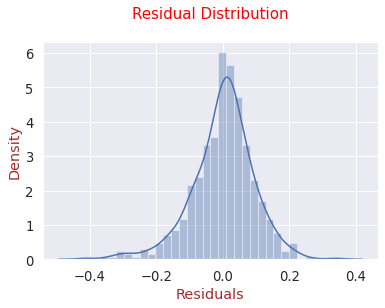

In [66]:
# checking residuals distribution

sns.distplot(res)
plt.xlabel('Residuals',fontdict={'color':'brown'})
plt.ylabel('Density',fontdict={'color':'brown'})
plt.title('Residual Distribution\n',fontdict={'fontsize':15, 'color':'red'})
plt.show()

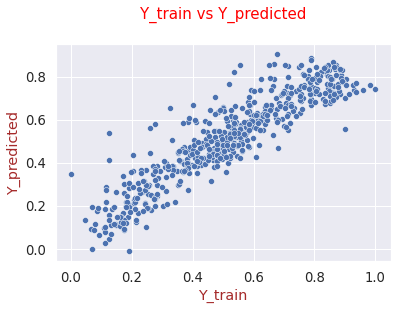

In [67]:
# scatter plot between the actual value and the predicted values.   

sns.scatterplot(Y_train,y_pred)

plt.xlabel('Y_train',fontdict={'color':'brown'})
plt.ylabel('Y_predicted',fontdict={'color':'brown'})
plt.title('Y_train vs Y_predicted\n',fontdict={'fontsize':15, 'color':'red'})
plt.show()


- Residuals are equally distributed across the regression line i.e. above and below the regression line and the variance of the residuals are same for all predicted scores along the regression line.

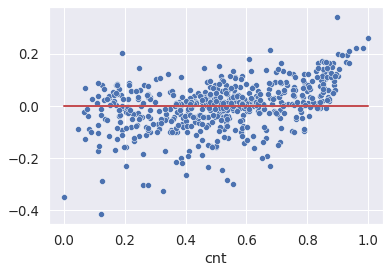

In [68]:
# Scatter plot of the residuals wrt the actual values.

plt.figure()
sns.scatterplot(Y_train,res)
plt.plot(Y_train,res*0,'r')
plt.show()

# Test Datset Prediction.

In [69]:
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thur,tue,wed,light snow,mist
184,0,1,0,29.793347,63.7917,5.459106,6043,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
535,1,0,1,32.082500,59.2083,7.625404,6211,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
299,0,0,0,19.270000,81.2917,13.250121,2659,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
221,0,0,1,31.433347,42.4167,13.417286,4780,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
152,0,0,0,29.315000,30.5000,19.583229,4968,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [70]:
# Transforming the test data with the scale object creted on train set.

var1 = ['temp','hum','windspeed','cnt']
df_test[var1] = scaler.transform(df_test[var1])
df_test.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thur,tue,wed,light snow,mist
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,0.475410,0.032787,0.606557,0.568688,0.635166,0.316439,0.530233,0.213115,0.273224,0.240437,0.060109,0.076503,0.087432,0.071038,0.125683,0.092896,0.049180,0.087432,0.081967,0.076503,0.087432,0.120219,0.196721,0.169399,0.147541,0.092896,0.136612,0.032787,0.300546
std,0.500765,0.178567,0.489854,0.234887,0.152926,0.159371,0.215783,0.410632,0.446837,0.428521,0.238341,0.266530,0.283242,0.257593,0.332401,0.291083,0.216838,0.283242,0.275067,0.266530,0.283242,0.326109,0.398610,0.376133,0.355617,0.291083,0.344380,0.178567,0.459754
min,0.000000,0.000000,0.000000,0.046591,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.362754,0.522601,0.199183,0.393293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.575304,0.618721,0.303464,0.533134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.774153,0.735079,0.404383,0.681086,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
# deviding the dataset into dependant and independant variables.

Y_test = df_test.pop('cnt')
X_test = df_test

In [72]:
# adding constant to the independant features.

X_test_lm = sm.add_constant(X_test)

In [73]:
# taking only those columns which required for making predictions.

X_test_lm = X_test_lm[X_train_man.columns]
X_test_lm.head()

,const,yr,holiday,temp,hum,windspeed,spring,winter,july,light snow
184,1.0,0,1,0.831783,0.657364,0.084219,0,0,1,0
535,1.0,1,0,0.901354,0.610133,0.153728,0,0,0,0
299,1.0,0,0,0.511964,0.837699,0.334206,0,1,0,0
221,1.0,0,0,0.881625,0.437098,0.339570,0,0,0,0
152,1.0,0,0,0.817246,0.314298,0.537414,0,0,0,0


In [74]:
# predicting the values for the test dataset from model created on train dataset.

y_test_pred = lm_final.predict(X_test_lm)

# Test dataset Residual analysis

In [75]:
# calculating the residual for test dataset.

test_res = y_test_pred - Y_test

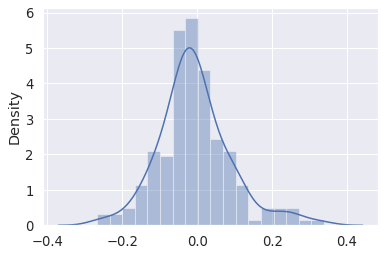

In [76]:
# checking the resudials distribution. 

sns.distplot(test_res)
plt.show()

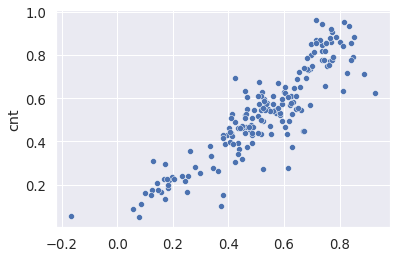

In [77]:
# scatter plot between the actual value and the predicted values.   

sns.scatterplot(y_test_pred,Y_test)
plt.show()

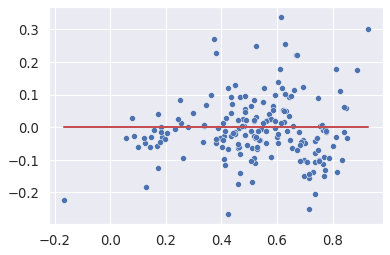

In [78]:
# Scatter plot of the residuals wrt the actual values.

plt.figure()
sns.scatterplot(y_test_pred,test_res)
plt.plot(y_test_pred,test_res*0,'r')
plt.show()

# R2 for Test data set

In [79]:
R2 = round(r2_score(Y_test,y_test_pred),3)
R2

0.796

# Insights from EDA
    . year - The users have increased over time from the year 2018 - 37.8% to the year 2019 - 62.2%.
    . season - The customers prefer to use the bikes during fall season and not much users in spring season.
    . Month.
        1. May,June,July, August and September months where users are more and constant.
        2. from October the users starts declining till January.
        3. from February the users starts increasing till April.
    . weekdays - all the weekdays show almost same number of users.
    . Workingdays - more people prefer to use the bikes sharing on working days than on holidays.
    . weathersit - more users when the weather is clear and very low users on light snow weather.
    . temp - There is some linear relationship exist between temp and "cnt", with positive correlation of 0.62.
    . spring - this dummy variable has highest negative correlation with "cnt" i.e -0.56


# Conclusion over model

The final equation for the prediction is.<br>
#### cnt = 0.3697 + 0.2261 x yr - 0.1055 x holiday + 0.5343 x temp - 0.2652 x hum - 0.1967 x windspeed - 0.1065 x spring + 0.0672 x winter + 0.0934 x july - 0.1968 x light snow

#### train R2 = 0.829.              <br>
#### train Adjusted R2 = 0.82.      <br>
#### test R2 = 0.806.               <br>
#### test Adjusted R2 = 0.77.      <br>

#### Positively effecting features.
    • The good temperature attracting more customers use the bikes.
    • The use of bike sharing expected to increase every year may be due to it's popularity or ease of use.
    • the season winter also attracting more customers.
    • the customers are likely to increase in july month.
#### Negatively effecting features.
    • The number of user likely to decrease on Holidays.
    • The more the Humid weather and windy weather resulting less customers are likely use the bikes may be due chances of rain or snow.
    • During spring season the decline in the bike usage.
    . Customers barely using the bikes in light snow weather.